In [8]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-11-30

Goals: 
Fit the data

Each Section can/should run independently,
only these initial imports should be shared among all sections

Open questions:
None at the moment
"""

import os

import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from tqdm import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [9]:
import dask
# many workers
# dask.config.set(scheduler='threads') 

dask.config.set({"temporary-directory" :'/epyc/ssd/users/ncaplar/tmp'})

# does not work
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(20))

# one worker
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=12, threads_per_worker=1)
client = Client(cluster)
# cluster.adapt(minimum=10, maximum=40) 

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39186 instead
  warnings.warn(


In [10]:
dask.config.get("temporary-directory")

'/epyc/ssd/users/ncaplar/tmp'

In [11]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39186/status,
Dashboard: http://127.0.0.1:39186/status,Workers: 12
Total threads: 12,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45335,Workers: 12
Dashboard: http://127.0.0.1:39186/status,Total threads: 12
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:42116,Total threads: 1
Dashboard: http://127.0.0.1:34073/status,Memory: 20.97 GiB
Nanny: tcp://127.0.0.1:33941,


In [12]:
dask.config.get("temporary-directory")

'/epyc/ssd/users/ncaplar/tmp'

In [13]:
# Setup base directory for saving output files
username= "ncaplar"
basedir = f"/astro/users/{username}/data/"

# Alerce alerts

In [14]:
datapath = "/astro/store/epyc3/data3/alerce_alerts/parquet/"

names = []
for i in range(12,36):
    name = datapath+f"source/lcs_00{i}.parquet"
    names.append(name)

# Ensemble already initialized in the start
# ens = Ensemble()

colmap = ColumnMapper(id_col="oid",
                      time_col="mjd",
                      flux_col="magpsf_corr",
                      err_col="sigmapsf_corr_ext",
                      band_col="fid")
ens.from_parquet(source_file=names,
                #source_file=datapath+"source/lcs_000*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sort=True)

ens.dropna()
ens.query("fid == 1", table="source").prune(30)

ens.calc_nobs()
ens._sync_tables()

In [15]:
# to see where the divisions are
divisions = ens._source.divisions
divisions

('ZTF17aaaaabc',
 'ZTF17aabormw',
 'ZTF17aacuvzw',
 'ZTF18aakpybb',
 'ZTF18aaofepd',
 'ZTF18aaypnmw',
 'ZTF18aaznerf',
 'ZTF18abactld',
 'ZTF18abcofin',
 'ZTF18abfjqcx',
 'ZTF18abhpnuv',
 'ZTF18abijwil',
 'ZTF18abmvulj',
 'ZTF18abrliwv',
 'ZTF18absqkhh',
 'ZTF18abvbjir',
 'ZTF18acbcfgz',
 'ZTF18acuxonp',
 'ZTF18adbdlja',
 'ZTF19aacpxzf',
 'ZTF19aayeptv',
 'ZTF19abbpapf',
 'ZTF19acyetlk',
 'ZTF20abgttwz',
 'ZTF23abawsji')

In [16]:
# 42 sec when conda on epyc/user
# 32 sec when conda env on ssd

# Define a function to compute the number of rows in a partition
def count_rows(partition):
    return len(partition)

# Use the map function to apply the count_rows function to each partition
n_sources_per_div = ens._source.map_partitions(count_rows, meta=int).compute()

print("Number of rows in each partition:", n_sources_per_div)

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


Number of rows in each partition: 0     150394
1      97036
2     226855
3      42423
4     232392
5      53838
6      31915
7     186916
8     134159
9      55371
10     19913
11    203379
12    113680
13     45577
14     82001
15     86983
16    134043
17     35292
18     18409
19     67974
20      5524
21     46182
22      9937
23      1839
dtype: int64


In [17]:
# Let us try the same thing again
n_sources_per_div = ens._source.map_partitions(count_rows, meta=int).compute()

print("Number of rows in each partition:", n_sources_per_div)

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/dataframe/core.py:7234: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


Number of rows in each partition: 0     150394
1      97036
2     226855
3      42423
4     232392
5      53838
6      31915
7     186916
8     134159
9      55371
10     19913
11    203379
12    113680
13     45577
14     82001
15     86983
16    134043
17     35292
18     18409
19     67974
20      5524
21     46182
22      9937
23      1839
dtype: int64


In [18]:
ens.check_lightcurve_cohesion()

True

In [19]:
# how many objects
print(len(ens._object))

31892


In [20]:
ens._source = ens._source.repartition(npartitions=32, force=True)

unique_lengths: 336


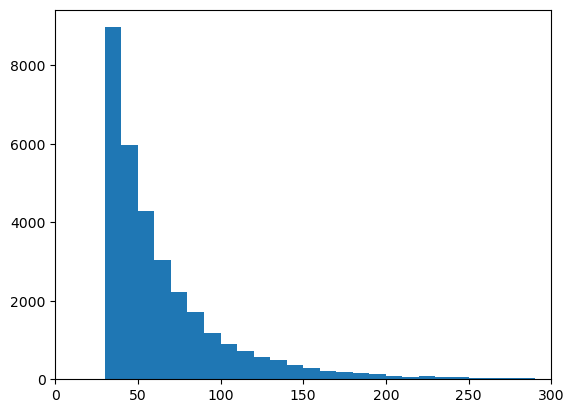

In [21]:
nobs_data = ens._object["nobs_total"].values.compute()
binwidth=10
plt.hist(nobs_data, bins=np.arange(min(nobs_data), max(nobs_data) + binwidth, binwidth))
plt.xlim(0,300)

print(f"unique_lengths: {len(np.unique(nobs_data))}")

In [ ]:
# 12 workers - 35 min on epyc (96 thread) on 32 partitions
# 12 with 1 thread - ? min on epyc  on 12 partitions - 35 min 
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd', "magpsf_corr", "sigmapsf_corr",
                compute=True, meta=None, n_init=100)